<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Optimización de los ángulos del PSG y PSA para la matriz de Jones del SLM Holoeye</font>
</div>

- **Para**: Cargar la calibración del SLM como objeto de py_pol y utilizarla

- **Fecha**: 2021/11/10
        
- **Autores**: 
    - Jesús del Hoyo
    - Luis Miguel Sánchez
    - Ángela Soria 
    

- **Objetivos**: - 

- **Descripción** - 

- **Referencias**: -


# Introducción

Optimización de los ángulos de los polarizadores y retardadores del PSA y PSG para obtener modulación en amplitud o fase. La matriz de Jones del SLM es la del modulador Holoeye del laboratorio.

# Desarrollo 

Cargar modulos

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt


from diffractio import degrees
from py_pol.jones_matrix import Jones_matrix,Jones_vector
from py_pol.mueller import Mueller


from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

number of processors: 8
total memory        : 15.5 Gb
available memory    : 56 %
max frequency       : 3100 GHz


In [4]:
def cargar_Jones_SLM(type="Jones"):
    """Funcion para cargar la calibración del SLM y convertirlo a un objeto py_pol.
    
    Args:
        type (str): Tipo de objeto, Jones o Mueller.
        
    Returns:
        M (Jones_matrix o Mueller): Resultado"""
    data = np.load("SLM_Jones_components.npz")
    components = [data["J0"] * np.exp(1j * data["d0"]),
                 data["J1"] * np.exp(1j * data["d1"]),
                 data["J2"] * np.exp(1j * data["d2"]),
                 data["J3"] * np.exp(1j * data["d3"])]
    M = Jones_matrix().from_components(components)
    
    if type.lower() == "mueller":
        M2 = Mueller().from_Jones(M)
        M = M2
    
    return M                     

In [5]:
def SLM_system_field(angles, Jslm, E0=None):
    """Function that calculates the transmission (amplitude and phase) of the PSG + SLM + PSA system.

    Args:
        angles (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm (Jones_matrix): Jones matrix of the SLM.
        states (bool): If True, angles is [PSG_az, PSG_el, PSA_az, PSA_el] instead of rotation angles. Default: False.
        E0 (Jones_vector or None). Source Jones vector. If None, circular polarization is used.

    Returns:
        int (np.ndarray): Intensity of final state.
        phase (np.ndarray): Global phase of final state.
    """
    # Create objects
    if E0 is None:
        E0 = Jones_vector().circular_light(intensity=2)
        
    if np.isnan(angles[0]) or angles[0] < 0:
        P1 = Jones_matrix().vacuum()
    else:
        P1 = Jones_matrix().diattenuator_perfect(azimuth=angles[0])
    if np.isnan(angles[1]) or angles[1] < 0:
        Q1 = Jones_matrix().vacuum()
    else:
        Q1 = Jones_matrix().quarter_waveplate(azimuth=angles[1])
    if np.isnan(angles[2]) or angles[2] < 0:
        Q2 = Jones_matrix().vacuum()
    else:
        Q2 = Jones_matrix().quarter_waveplate(azimuth=angles[2])
    if np.isnan(angles[3]) or angles[3] < 0:
        P2 = Jones_matrix().vacuum()
    else:
        P2 = Jones_matrix().diattenuator_perfect(azimuth=angles[3])
    # print(P1, Q1, Q2, P2, sep='\n')

    # Calculate final state
    Efinal = (P2 * Q2) * (Jslm * (Q1 * P1 * E0))

    # Extract phase and amplitude
    phase = Efinal.parameters.global_phase()
    phase -= phase[0]
    phase = phase % (2 * np.pi)
    phase = np.unwrap(phase)
    intensity = Efinal.parameters.intensity()
    amplitude = np.sqrt(intensity)
    
    return amplitude, phase, Efinal

In [39]:
def cost_amplitude(angles,Jslm):
    """
    Cost function to obtain a properly SLM amplitude configuration 
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        
    Returns:
        cost: (float): Value of merit function of a SLM phase configuration
        
    """
    
    amplitude, phase, _ = SLM_system_field(angles, Jslm, E0=None) 
    cost = -(amplitude.max() - amplitude.min())
    cost = -np.std(amplitude)
    
    return cost

In [40]:
def cost_phase(angles,Jslm):
    """
    Cost function to obtain a properly SLM phase configuration 
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        
    Returns:
        cost: (float): Value of merit function of a SLM phase configuration
        
    """
    
    amplitude, phase, _ = SLM_system_field(angles, Jslm, E0=None) 
    cost = -(phase.max() - phase.min())/np.std(amplitude)
    
    return cost

In [41]:
def optimization_loop(angles,Jslm,optimize_function):
    """
    Optimization loop of the particules of PySwarms algorithm.
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        optimize_function (function): Function to optimize.
    
    Returns:
        cost: (float): Value of merit function
    
    """
    n_particles = angles.shape[0]
    cost = [cost_phase(angles[i,:],Jslm) for i in range(n_particles)]
    
    return cost

In [42]:
def optimize_SLM_system(merit_function,Jslm,iters,n_particles,dimensions,options,bounds,optimization_loop):
    
    """
    This function search the best angles for a certain configuration of a SLM system.
    
    Args:
        merit_function: (function): Merit function to obtain an amplitude or phase configuration.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        iters: (int): Number of iterations.
        n_particles: (int): Number of particles.
        dimensions: (int): Number of dimensions of our optimization.
        options: (dict): Dictionary with the options of PySwarms algorithm. Example: options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
        bounds: (np.array,np.array): Maximum and minimum bounds of the angles. Example: min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions); bounds = (min_bound, max_bound).
        optimize_loop (function): Necessary function to use PySwarms algorithm.
        
    Returns:
        cost: (float): Value of merit function
        angles: (np.array): Best angles for a certain SLM configuration.
    

    """
    
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)
    cost, angles = optimizer.optimize(optimization_loop,iters,Jslm=Jslm,optimize_function=merit_function)
    
    return cost,angles

In [43]:
Jslm = cargar_Jones_SLM()
options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
dimensions = 4
min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions)*360*degrees
bounds = (min_bound, max_bound)

In [44]:
cost, angles_phase =  optimize_SLM_system(cost_phase,Jslm,50,20,4,options,bounds,optimization_loop)

2021-11-18 17:43:43,971 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-347
2021-11-18 17:43:55,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -347.0953130333076, best pos: [4.77639286 2.93373652 3.02485243 1.69897422]


In [45]:
cost, angles_amplitude =  optimize_SLM_system(cost_amplitude,Jslm,50,20,4,options,bounds,optimization_loop)

2021-11-18 17:43:55,436 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-683
2021-11-18 17:44:06,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -683.0238452462615, best pos: [4.62234947 4.72880733 1.52897844 3.98675883]


In [46]:
gl=np.array(range(0,256))

In [47]:
angles_phase_back     = [4.8175487,  0.01581232, 1.75758677, 1.15229228]

angles_amplitude = [1.3435567,  4.61762895, 2.74708301, 1.64830033]

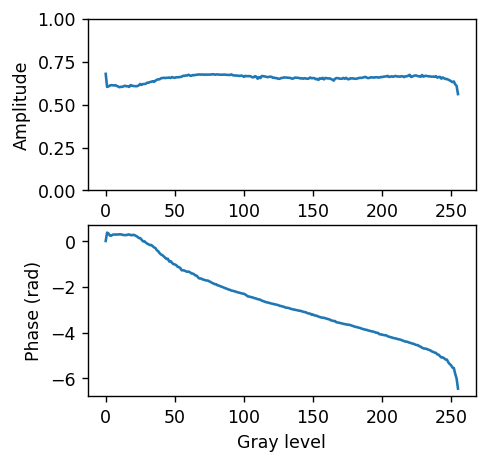

In [48]:
amplitude, phase,_ = SLM_system_field(angles_phase,Jslm)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gl, amplitude)
ax1.set_xlabel('Gray level'); ax1.set_ylabel('Amplitude')
ax1.set_ylim([0, 1])
ax2.set_xlabel('Gray level'); ax2.set_ylabel('Phase (rad)')
ax2.plot(gl, phase)

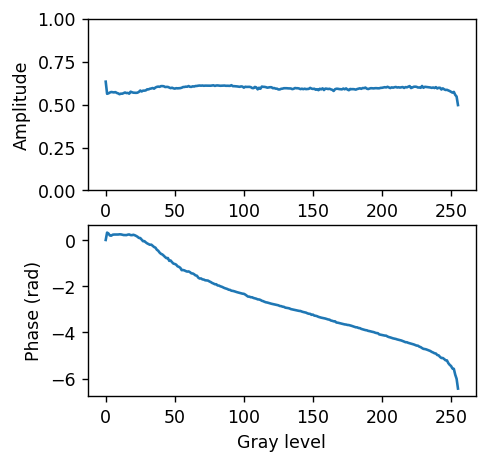

In [49]:
amplitude, phase,_ = SLM_system_field(angles_amplitude,Jslm)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gl, amplitude)
ax1.set_xlabel('Gray level'); ax1.set_ylabel('Amplitude')
ax1.set_ylim([0, 1])
ax2.set_xlabel('Gray level'); ax2.set_ylabel('Phase (rad)')
ax2.plot(gl, phase)